In [ ]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

In [1]:
import fdasrsf as fs
import numpy as np

In [2]:
from fdasrsf.utility_functions import elastic_distance

In [2]:
import numpy as np

#ys = np.loadtxt('trajs.txt')
ys = np.load('ys_curlp.npy')[:,:,0]
#pids = np.loadtxt('pids.txt', dtype='str')
cohorts = np.loadtxt('cohorts_new.txt', dtype='str')
#muscle_scores = np.loadtxt('muscle_scores.txt')

In [4]:
ys = np.loadtxt('ys_curl_wodelta.txt')
pids = np.loadtxt('pids_curl_wodelta.txt')
visits = np.loadtxt('visits_curl_wodelta.txt', dtype=str)
cohorts = np.loadtxt('cohorts_new.txt', dtype='str')

print(len(ys), len(pids), len(visits), len(cohorts))

70 70 70 70


/tmp/ipykernel_415494/15737429.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


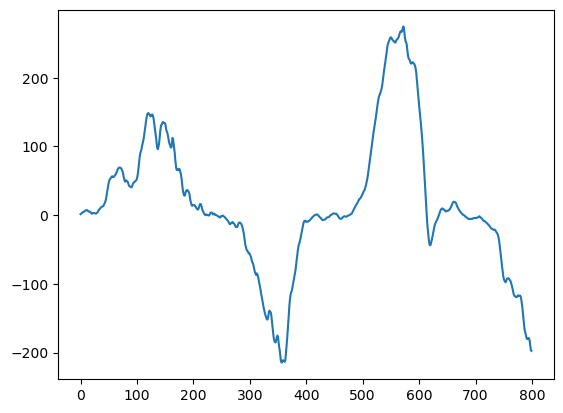

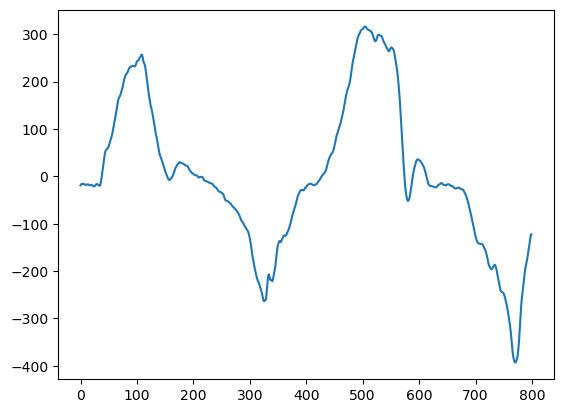

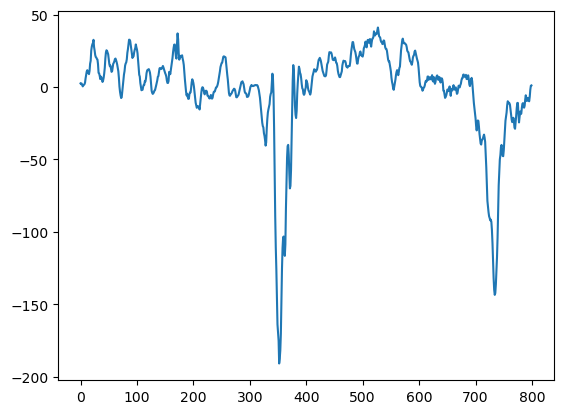

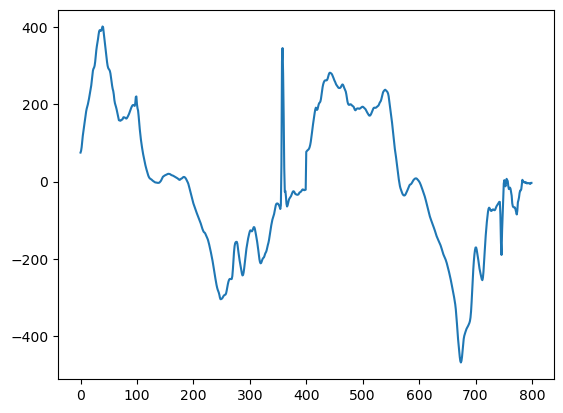

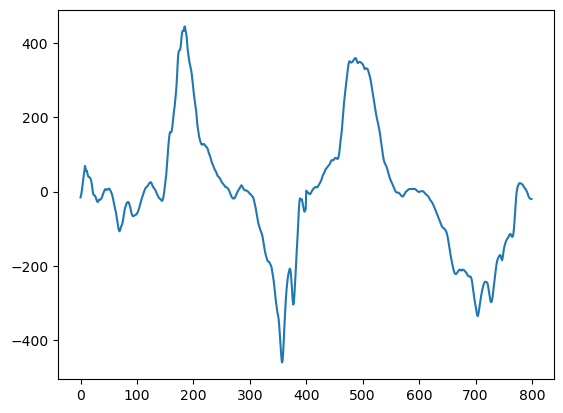

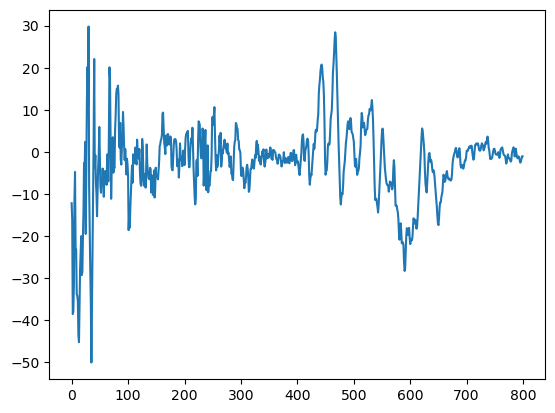

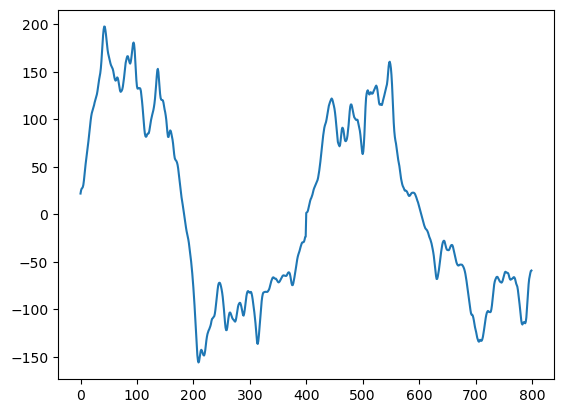

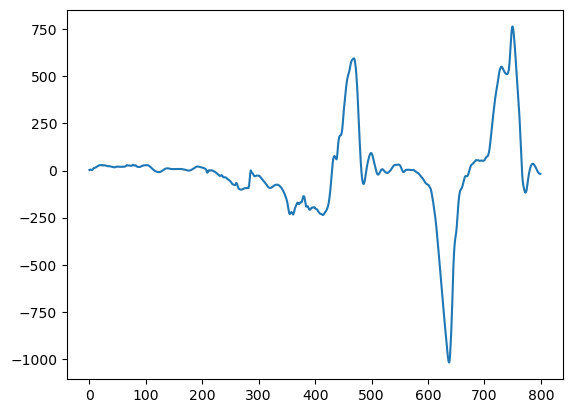

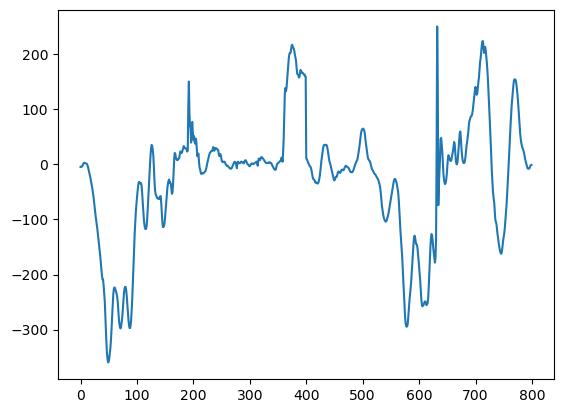

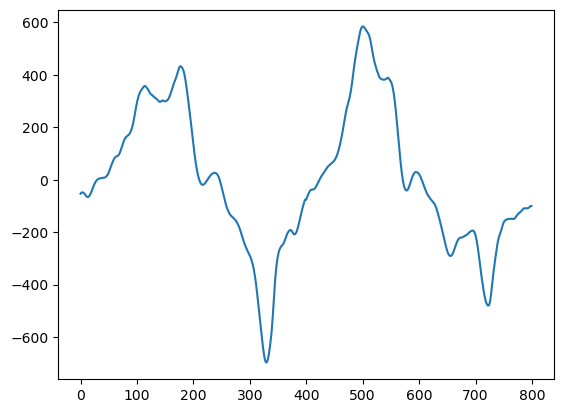

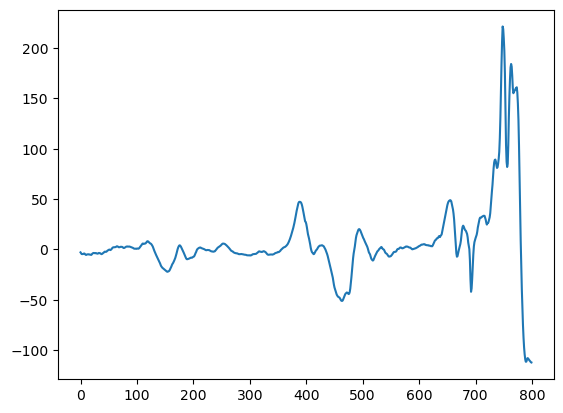

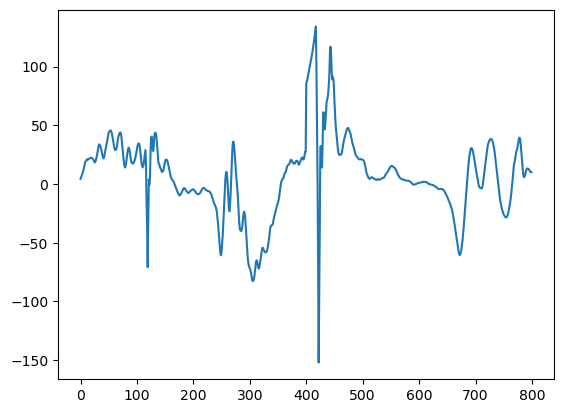

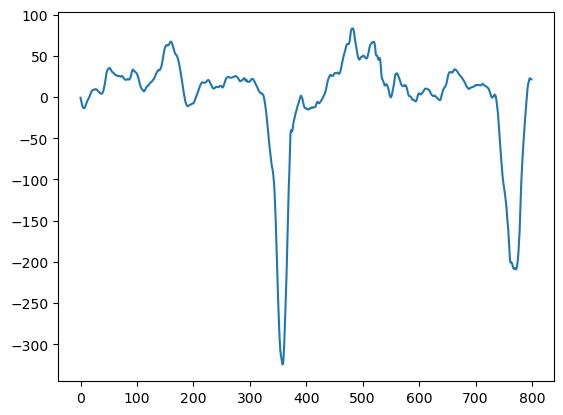

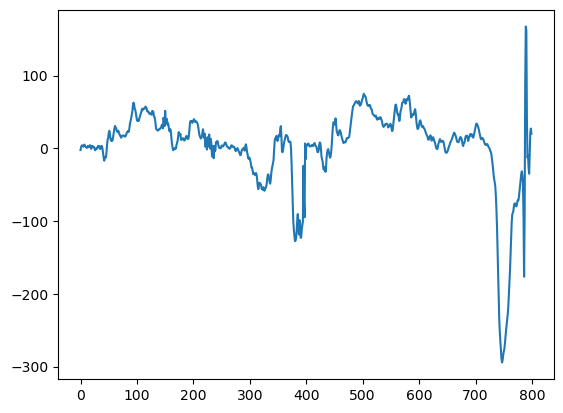

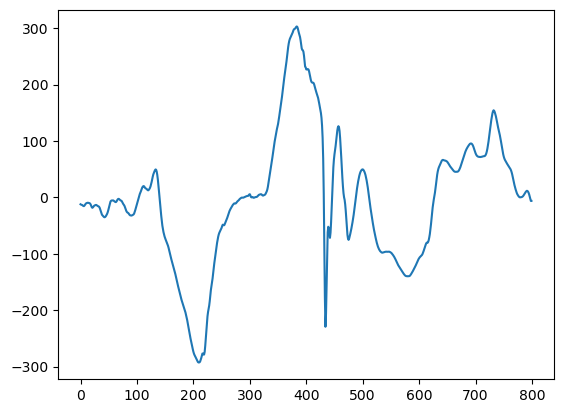

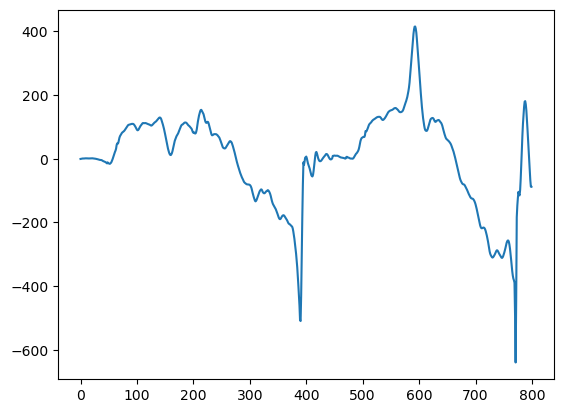

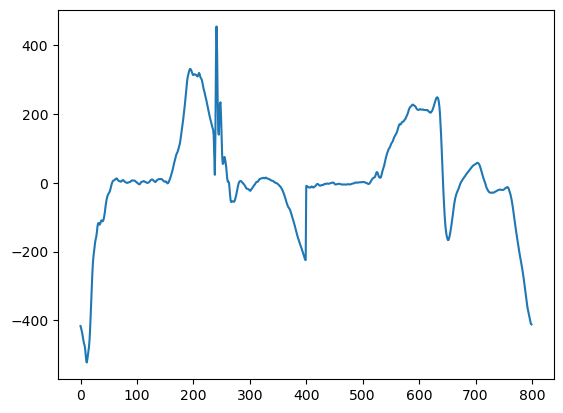

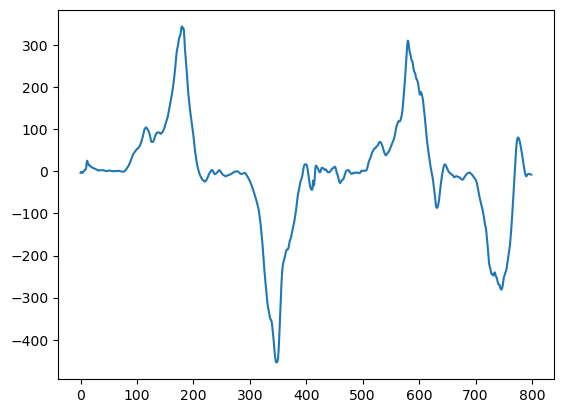

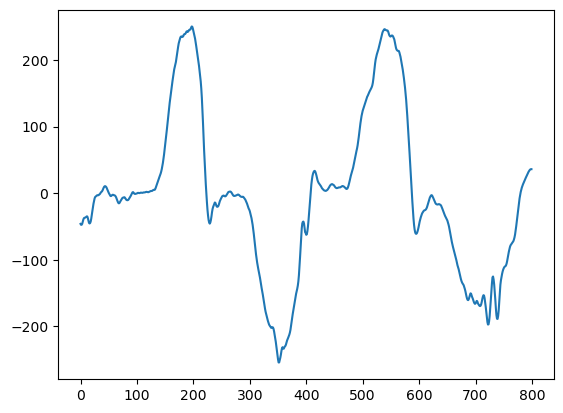

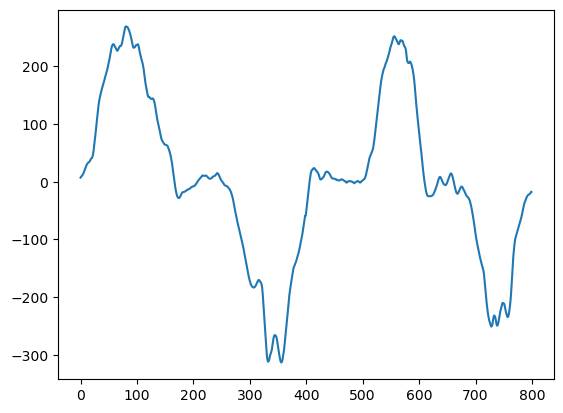

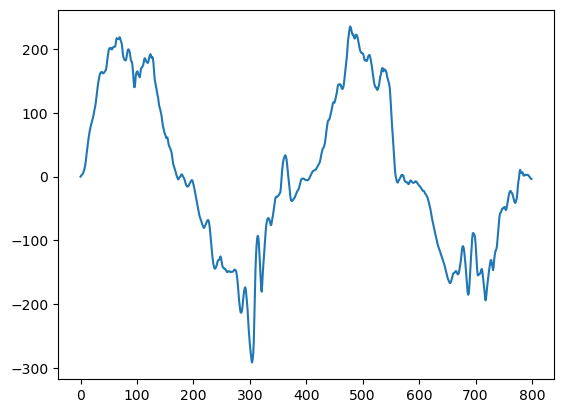

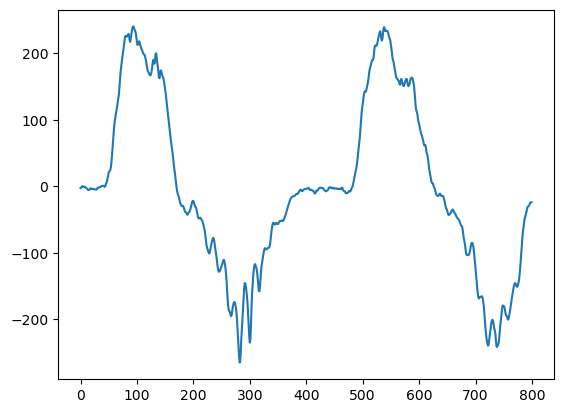

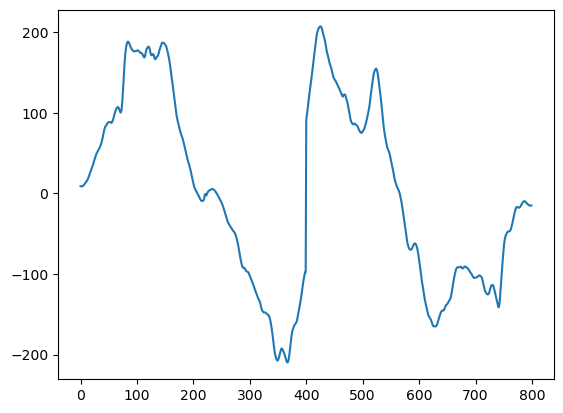

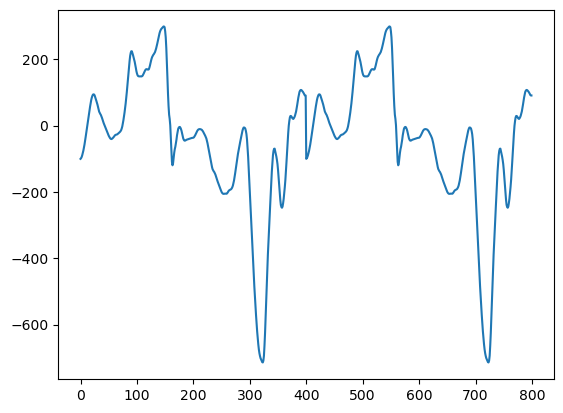

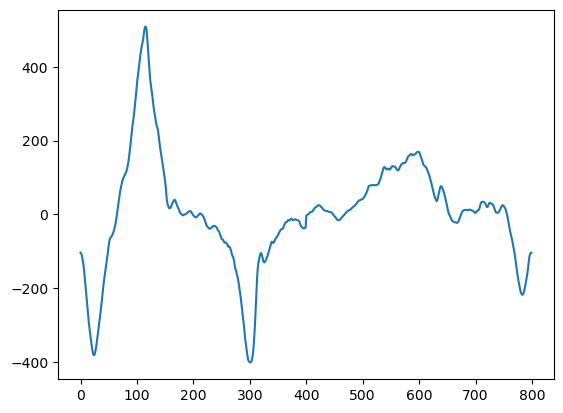

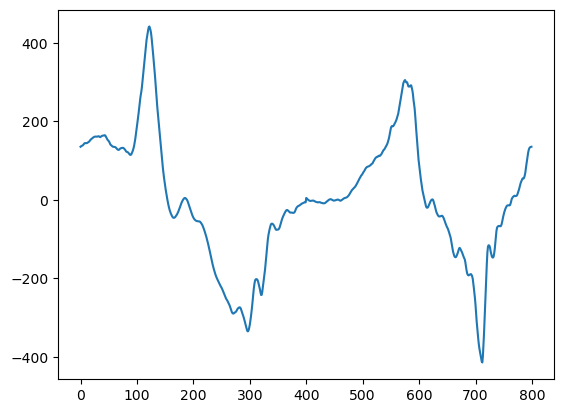

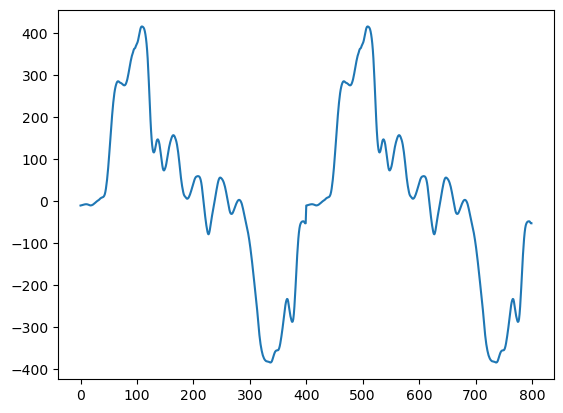

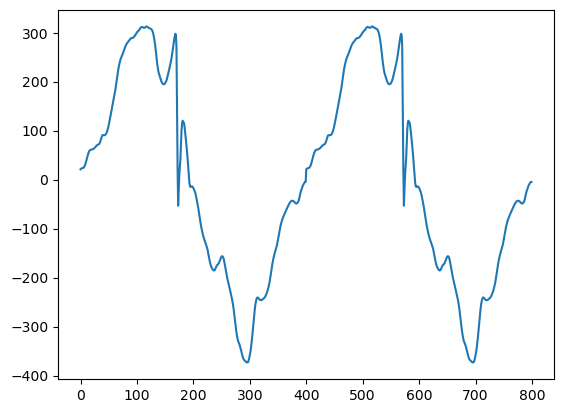

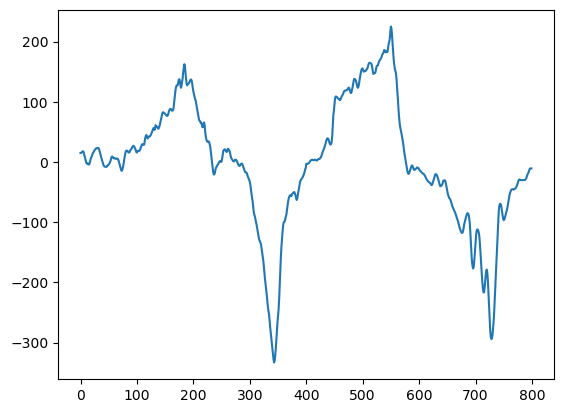

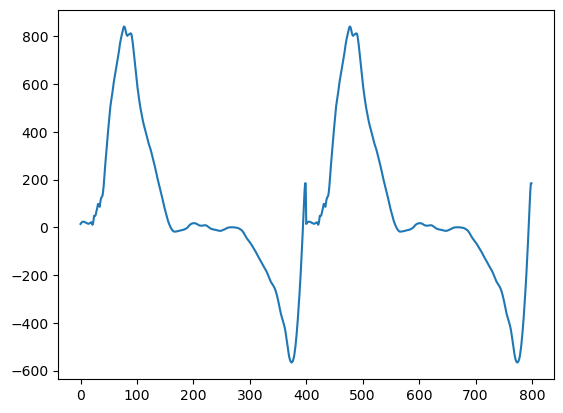

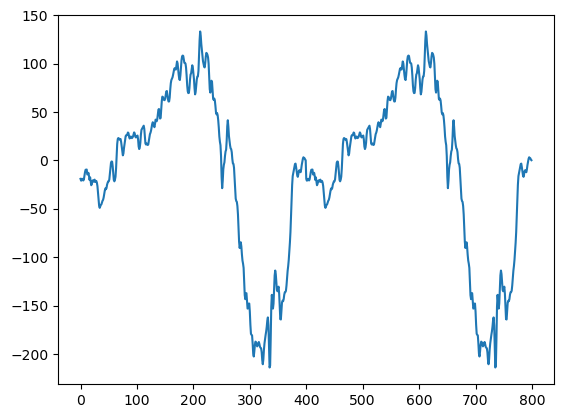

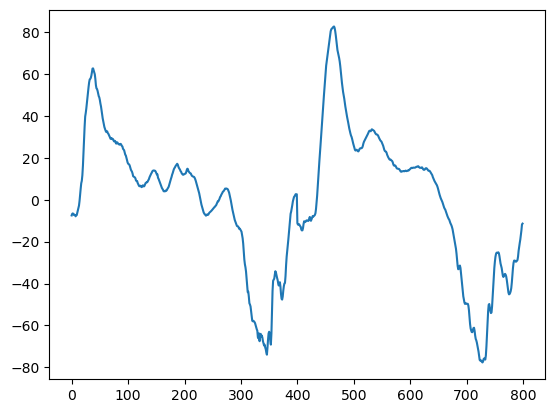

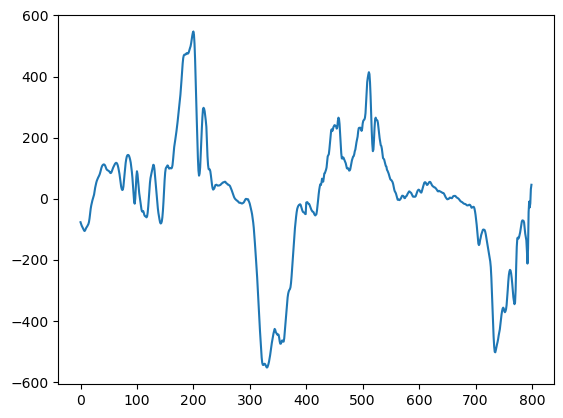

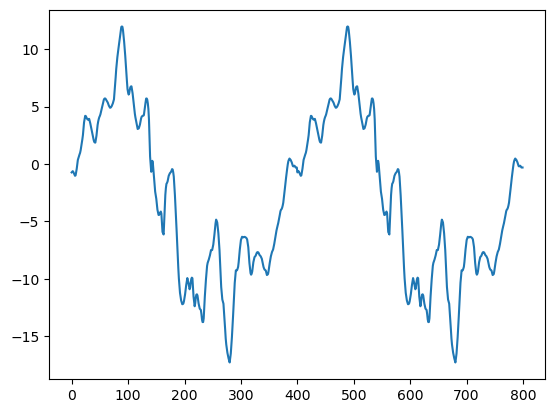

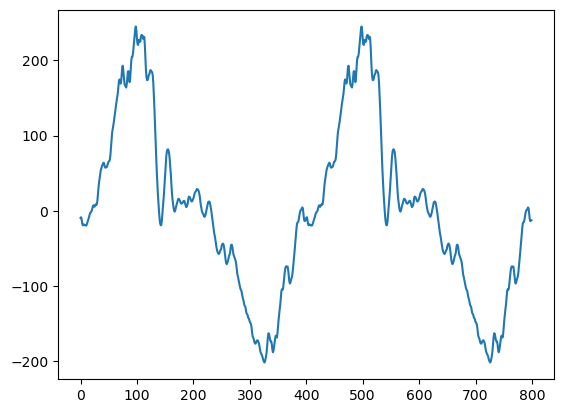

In [5]:
import matplotlib.pyplot as plt

newys = []
newpids = []
newvisits = []
newcohorts = []

for i in range(0, len(ys), 2):
    ysarray = np.array(ys)
    newys.append(np.concatenate((ysarray[i, :], ysarray[i+1, :])))
    newpids.append(pids[i])
    newvisits.append(visits[i])
    newcohorts.append(cohorts[i])

for i in range(len(newys)):
    plt.figure()
    plt.plot(newys[i])

In [6]:
ys = newys
pids = newpids
visits = newvisits
cohorts = newcohorts

len(ys), len(pids), len(visits), len(cohorts)

(35, 35, 35, 35)

In [7]:
def random_sample(group):
    return group.sample(n=1)

In [8]:
import pandas as pd

df_processor = pd.DataFrame(ys)
df_processor['pids']=pids
df_processor['visits']=visits
df_processor['cohorts']=cohorts

In [9]:
random_rows = df_processor.groupby(['pids']).apply(random_sample).reset_index(drop=True)
ys = random_rows.iloc[:,0:800].values
cohorts = random_rows['cohorts']

len(ys), len(cohorts)

/tmp/ipykernel_415494/2535494318.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  random_rows = df_processor.groupby(['pids']).apply(random_sample).reset_index(drop=True)


(31, 31)

In [10]:
pids = random_rows['pids']
visits = random_rows['visits']

In [11]:
idx_healthy = np.where(cohorts=='Healthy')
idx_not_healthy = np.where(cohorts!='Healthy')

In [ ]:
time = np.array(range(800)).astype(float)
obj_all = fs.fdawarp(np.transpose(ys), time)

obj_all.srsf_align(parallel=True, smoothdata=True)

Initializing...
Compute Karcher Mean of 31 function in SRSF space with lam=0.000000
updating step: r=1
updating step: r=2
updating step: r=3


In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(30, 3))
vpca = fs.fdavpca(obj_all)
vpca.calc_fpca(no=3)
vpca.plot()

In [84]:
# data = pd.DataFrame(ys)
# data = pd.DataFrame(obj_all.qn.T)
data = pd.DataFrame(obj_all.fn.T)

data['cohort'] = cohorts
data['pids'] = pids.astype(int)

cohort_order = pd.Categorical(data['cohort'], categories=["Healthy", "DMD", "SMA"], ordered=True)
data['cohort'] = cohort_order

data['pids_cohort'] = data['pids'].astype(str) + data['cohort'].astype(str)

# Sort the DataFrame by the 'cohort' column
sorted_data = data.sort_values(by='cohort')
# sorted_data

In [104]:
from tslearn import metrics
from tqdm.notebook import tqdm
import numpy as np
from joblib import Parallel, delayed
from scipy.stats import pearsonr


def compute_distances(i):

    dist_pairwise_row = np.zeros(N)

    beta1 = betas_all[i]
    
    for j in tqdm(range(N)):

        beta2 = betas_all[j]
        
        # amp, phase = elastic_distance(beta1, beta2, time=np.linspace(0, 1, 800))
        # amp = np.linalg.norm(beta1-beta2)
        amp = 1- pearsonr(beta1, beta2)[0]
        dist_pairwise_row[j] = amp
    
    return dist_pairwise_row

betas_all = sorted_data.values[:,0:800]
N = len(betas_all)
dist_pairwise = np.zeros((N, N))

results = Parallel(n_jobs=-1)(delayed(compute_distances)(i) for i in tqdm(range(N)))

for i in tqdm(range(N)):
    dist_pairwise[i, :] = results[i]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

In [105]:
# dist_avg = (dist_pairwise + dist_pairwise.T)/2
dist_avg = dist_pairwise

In [106]:
dist_avg = pd.DataFrame(dist_avg, index=sorted_data['pids_cohort'], columns=sorted_data['pids_cohort'])

In [120]:
from sklearn.datasets import load_digits
from sklearn.manifold import TSNE
# from sklearn.manifold import MDS

# embedding = MDS(n_components=2, normalized_stress='auto', dissimilarity='precomputed')
# X_transformed = embedding.fit_transform(dist_avg.values)
# print(X_transformed.shape)

X_transformed = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=3).fit_transform(dist_avg.values)

dist_df = pd.DataFrame(X_transformed, columns=['Dim1','Dim2'])
dist_df['Cohort'] = sorted_data['cohort']
dist_df['pid'] = sorted_data['pids']

Text(0.5, 1.0, 'T-SNE')

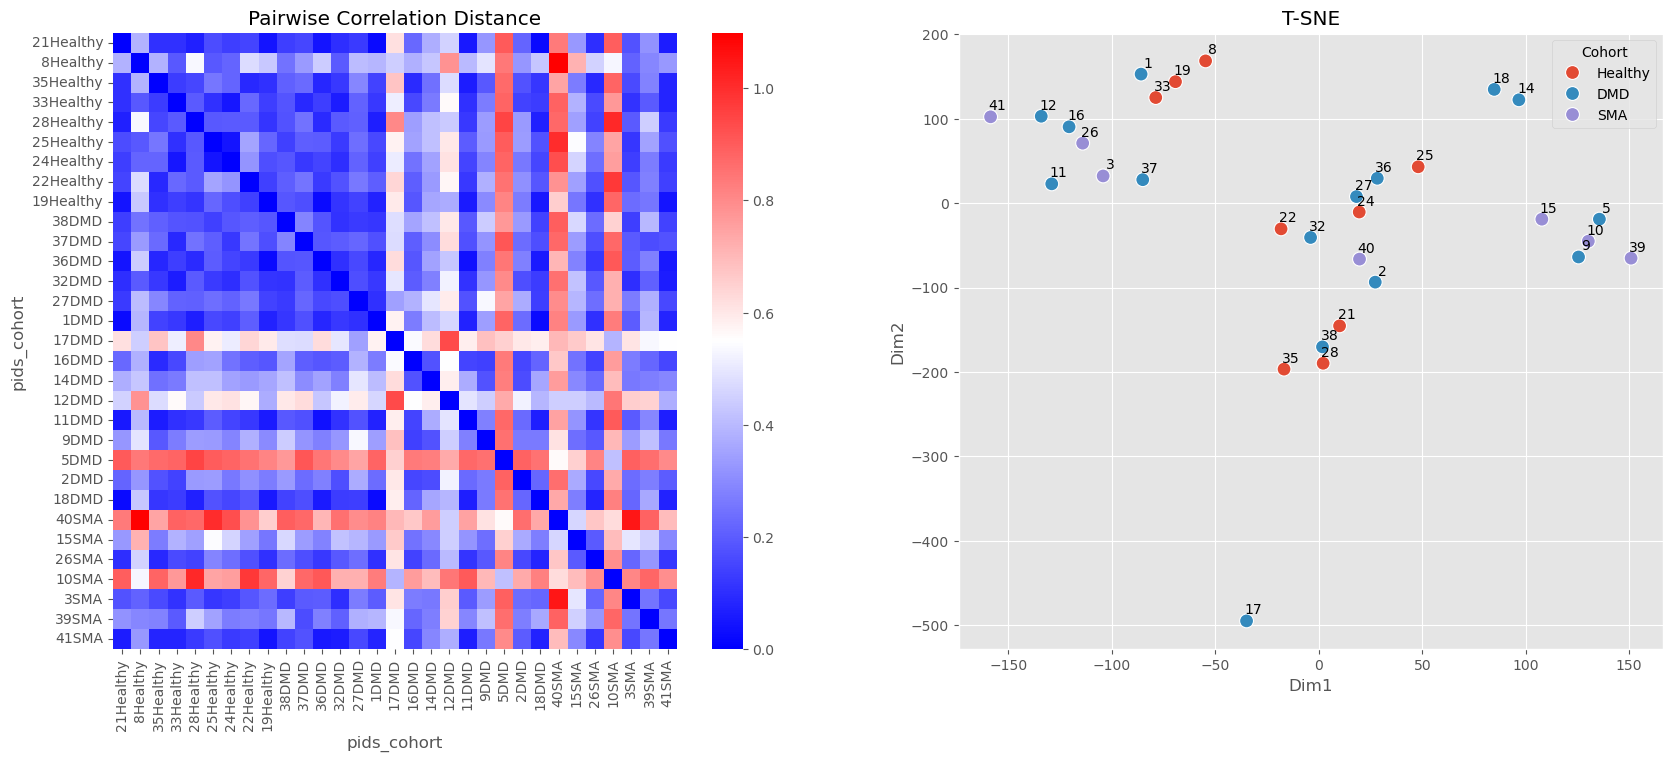

In [126]:
import seaborn as sns

fig, axs = plt.subplots(1, 2, figsize=(20, 8))

sns.heatmap(dist_avg, cmap='bwr', xticklabels=1, yticklabels=1, ax = axs[0])
axs[0].set_title('Pairwise Correlation Distance')

scatter_plot = sns.scatterplot(data=dist_df, x='Dim1', y='Dim2', hue='Cohort',ax = axs[1], s=100)

# Annotate each point with its index
for i in range(dist_df.shape[0]):
    axs[1].annotate(dist_df.loc[i,'pid'], (dist_df['Dim1'][i], dist_df['Dim2'][i]), textcoords="offset points", xytext=(5,5), ha='center')

axs[1].set_title('T-SNE')

# plt.savefig('pics/dist_mds.png', dpi=300, bbox_inches='tight')

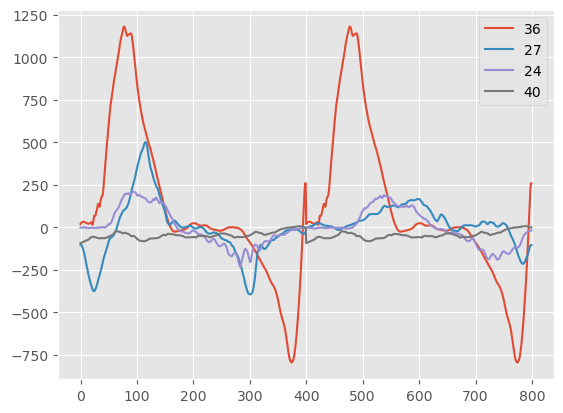

In [125]:
ps = [36, 27, 24, 40]

for p in ps:
    h1 = random_rows[random_rows['pids'] == p].values
    plt.plot(h1[:,0:800].T, label=p)

plt.legend()

In [61]:
elastic_distance(h1[0,0:800], h2[0,0:800], time=np.linspace(0, 1, 800))

(27.113012744691755, 0.48201110031965116)

In [62]:
elastic_distance(h1[0,0:800], d1[0,0:800], time=np.linspace(0, 1, 800))

(39.23970410847276, 0.5586800356592901)

In [63]:
elastic_distance(h2[0,0:800], d1[0,0:800], time=np.linspace(0, 1, 800))

(43.84545157373728, 0.5276229401241211)

In [65]:
elastic_distance(h3[0,0:800], d1[0,0:800], time=np.linspace(0, 1, 800))

(64.01597361269154, 0.580211692257466)

In [12]:
ys_healthy = ys[idx_healthy]
time = np.array(range(800)).astype(float)
obj_healthy = fs.fdawarp(np.transpose(ys_healthy), time)

In [13]:
obj_healthy.srsf_align(parallel=True)

Initializing...
Compute Karcher Mean of 9 function in SRSF space with lam=0.000000
updating step: r=1
updating step: r=2
updating step: r=3
updating step: r=4
updating step: r=5
updating step: r=6
updating step: r=7
updating step: r=8
updating step: r=9
updating step: r=10
updating step: r=11
updating step: r=12
updating step: r=13
updating step: r=14
updating step: r=15
updating step: r=16
updating step: r=17
updating step: r=18
updating step: r=19
updating step: r=20
maximal number of iterations is reached


In [ ]:
#obj_healthy.plot()

In [14]:
obj_all = fs.fdawarp(np.transpose(ys), time)

In [15]:
obj_dmdsma = fs.fdawarp(np.transpose(ys[idx_not_healthy]), time)
obj_dmdsma.srsf_align(parallel=True)

Initializing...
Compute Karcher Mean of 22 function in SRSF space with lam=0.000000
updating step: r=1
updating step: r=2
updating step: r=3
updating step: r=4
updating step: r=5
updating step: r=6
updating step: r=7
updating step: r=8
updating step: r=9
updating step: r=10
updating step: r=11
updating step: r=12
updating step: r=13
updating step: r=14
updating step: r=15
updating step: r=16
updating step: r=17
updating step: r=18
updating step: r=19
updating step: r=20
maximal number of iterations is reached


In [17]:
import seaborn as sns

/home/user/anaconda3/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


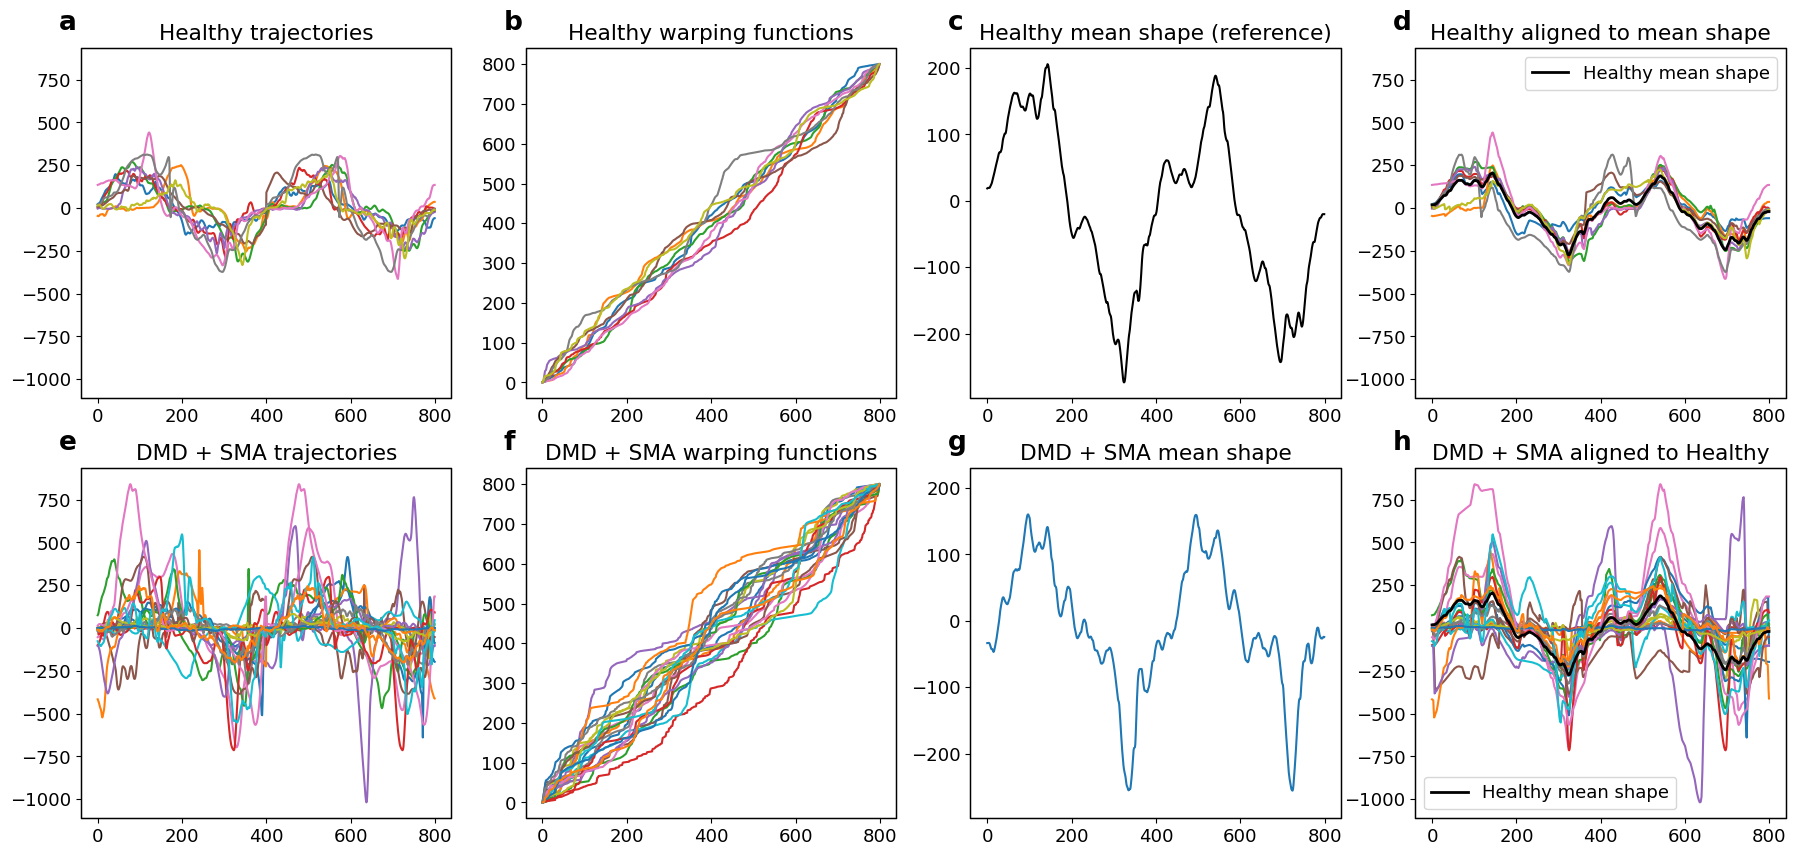

In [18]:
obj_all.multiple_align_functions(obj_healthy.fmean)

import matplotlib.pyplot as plt
plt.rcParams["figure.facecolor"] = "w"
plt.rcParams.update({'font.size': 13})


colors = np.repeat(u'tab:red', ys.shape[0])
colors[idx_healthy]='green'

fig, axs = plt.subplots(2,4, figsize=(22, 10), facecolor='white', sharey='col')
labels = ['a', 'b', 'c','d','e','f','g','h']
k = 0 

for i in range(2):
     for j in range(4):
        ax = axs[i,j]
        ax.tick_params(axis='x', colors='black')
        ax.tick_params(axis='y', colors='black')
        ax.set_facecolor('white')
        ax.patch.set_edgecolor('black')  
        ax.spines['bottom'].set_color('0')
        ax.spines['top'].set_color('0')
        ax.spines['left'].set_color('0')
        ax.spines['right'].set_color('0')
        ax.patch.set_linewidth(1)
        ax.text(-0.06, 1.11, labels[k], transform=axs[i, j].transAxes, fontsize=19, verticalalignment='top', fontweight='bold')
        k += 1 


for i in range(ys.shape[0]):
    
    
    if i not in idx_healthy[0]:
    
        axs[1,0].plot(ys[i]) # raw dmd_sma
        axs[1,1].plot(obj_all.gam[:,i]*800) # dmd_
        axs[1,3].plot(obj_all.fn[:,i])
    #axs[1,0].plot(obj_all.f.mean(axis=1))
    #axs[1,2].plot(obj.fmean)
    #axs[1,2].plot(obj.fn.mean(axis=1))


axs[0,0].set_title('Healthy trajectories')
axs[0,0].plot(obj_healthy.f)
axs[0,1].set_title('Healthy warping functions')
axs[0,1].plot(obj_healthy.gam*800)
axs[0,2].set_title('Healthy mean shape (reference)')
axs[0,2].plot(obj_healthy.fmean, color='black')

axs[0,3].plot(obj_healthy.fn)
axs[0,3].plot(obj_healthy.fmean, color='black',lw = 2, label='Healthy mean shape')
axs[0,3].legend(facecolor="white")
axs[1,3].plot(obj_healthy.fmean, color='black',lw = 2, label='Healthy mean shape')
axs[0,3].set_title('Healthy aligned to mean shape')


axs[1,0].set_title('DMD + SMA trajectories')
axs[1,1].set_title('DMD + SMA warping functions')
axs[1,3].set_title('DMD + SMA aligned to Healthy')


axs[1,2].set_title('DMD + SMA mean shape')
axs[1,2].plot(obj_dmdsma.fmean)
    
plt.legend(facecolor="white")
ax = plt.gca()
plt.savefig('./pics/phase_amp_dom.png', dpi=300, bbox_inches='tight')
#ax.set_facecolor('white')

In [ ]:
""" Raw plot of amplitude and phase distances """
from collections import defaultdict

amp_all = []
phase_all = []

amplitude_dists = defaultdict(list)
phase_dists = defaultdict(list)

for i in range(22):
    fig, axs = plt.subplots(1, 3, figsize=(15, 3))
    
    amplitude_dist, phase_dist = elastic_distance(obj_all.fn[:,i], obj.fmean, time)
    
    axs[0].plot(ys[i])
    axs[1].plot(obj_all.fn[:,i])
    axs[1].plot(obj_all.fmean)
    axs[2].plot(obj_all.gam[:,i])
    axs[0].set_title(pids[i])
    axs[1].set_title(cohorts[i] + ' ' + str(amplitude_dist))
    axs[2].set_title(cohorts[i] + ' ' + str(phase_dist))
    
    amplitude_dists[cohorts[i]].append(amplitude_dist)
    phase_dists[cohorts[i]].append(phase_dist)
    
    amp_all.append(amplitude_dist)
    phase_all.append(phase_dist)

In [ ]:
# import seaborn as sns
# sns.boxplot(amplitude_dists)

In [ ]:
from scipy import stats
fig, axs = plt.subplots(1, 2, figsize=(15, 3))

xlabels = ['amplitude distance', 'phase distance']

for i, dict1 in enumerate([amplitude_dists, phase_dists]):
    tstat, pval=stats.ttest_ind(dict1['DMD']+dict1['SMA'], dict1['Healthy'], equal_var=False)


    #dict1= amplitude_dists

    labels, data = [*zip(*dict1.items())]  # 'transpose' items to parallel key, value lists

    # or backwards compatable    
    labels, data = dict1.keys(), dict1.values()
    #ax = plt.gca()
    #ax.set_facecolor('white')
    box = axs[i].boxplot(data, patch_artist=True)



    colors = ['tab:red', 'tab:orange', 'tab:green']
    for patch, color in zip(box['boxes'], colors):
        patch.set_facecolor(color)

    axs[i].set_xticks(range(1, len(labels) + 1), labels)
    #axs[i].set_title("pha")
    #axs[i].set_title("amplitude distances: ")
    axs[i].set_title("t-statistic: {}, pval: {}".format(round(tstat, 3), round(pval, 5)))
    axs[i].set_xlabel(xlabels[i])

plt.legend()
plt.show()


In [ ]:
dict1

In [ ]:
dict1= phase_dists

tstat, pval = stats.ttest_ind(phase_dists['DMD'], phase_dists['Healthy'], equal_var=False)

labels, data = [*zip(*dict1.items())]  # 'transpose' items to parallel key, value lists

# or backwards compatable    
labels, data = dict1.keys(), dict1.values()

box = plt.boxplot(data, patch_artist=True)



colors = ['tab:red', 'tab:orange', 'tab:green']
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
plt.xticks(range(1, len(labels) + 1), labels)
plt.title("tstatistic: {}, pval: {}".format(tstat, pval))
plt.show()

In [ ]:
fig, axs = plt.subplots(1,2 )

In [ ]:
from tqdm import tqdm
from fdasrsf.utility_functions import elastic_distance

In [ ]:
def arcdist(a, b):
    return 1.0 - abs((np.transpose(a)@b)/(np.linalg.norm(a)*np.linalg.norm(b)))

phase_dist_mat = np.zeros((ys.shape[0], ys.shape[0]))
amplitude_dist_mat = np.zeros((ys.shape[0], ys.shape[0]))
    
for i in tqdm(range(len(ys))):
    for j in range(len(ys)):
        #amp_dist = arcdist(ys[i], ys[j])
        if i!=j:
            amp_dist = arcdist(ys[i], ys[j])
            a_dist, p_dist = elastic_distance(ys[i], ys[j], time)
            #amp_dist = arcdist(obj_all.fn[:,i], obj_all.fn[:,j])
        #
            print(p_dist, i, j)
            amplitude_dist_mat[i,j] = a_dist
            phase_dist_mat[i,j] = p_dist
        
#amplitude_dist_mat = np.clip(amplitude_dist_mat, 0, 1)

In [ ]:
amplitude_dist_mat[0, 1]

In [ ]:
amplitude_dist_mat

In [ ]:
X_embedded = MDS(n_components=2, metric='precomputed', max_iter=3000).fit_transform(amplitude_dist_mat)
X_embedded.shape

In [ ]:
import plotly.express as px
fig = px.scatter(x=X_embedded[:,0], y=X_embedded[:,1], text=pids, color=cohorts)
fig.show()

In [ ]:
pid_cohorts = [str(pids[i])+str(cohorts[i]) for i in range(len(pids))]

In [ ]:
import plotly.graph_objects as go

fig = go.Figure(data=go.Heatmap(
                   z=phase_dist_mat,
                   x=pid_cohorts,
                   y=pid_cohorts,
                   hoverongaps = False))
fig.show()

In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.cluster import pair_confusion_matrix

from sklearn.cluster import SpectralClustering
from sklearn.metrics.cluster import fowlkes_mallows_score


key_dict = {'DMD': 1, 'SMA': 1, 'Healthy': 0}
true_labels = [key_dict[l] for l in cohorts]


algorithms = [SpectralClustering(n_clusters=2, affinity='precomputed'), 
              AgglomerativeClustering(n_clusters=2, affinity='precomputed', linkage='single')]

for clustering in algorithms:
    clustering.fit(1.0-amplitude_dist_mat)
    #print(fowlkes_mallows_score(true_labels, clustering.labels_))
    print(f1_score(true_labels, clustering.labels_))
    print(pair_confusion_matrix(true_labels, clustering.labels_))



In [ ]:
algorithms = SpectralClustering(n_clusters=2, affinity='precomputed')
algorithms.fit(amplitude_dist_mat)
print(algorithms.labels_)
print(true_labels)

In [ ]:
from sklearn.metrics import f1_score

In [ ]:
from sklearn_extra.cluster import KMedoids


In [ ]:
cluster.fit(amplitude_dist_mat)

In [ ]:
cluster.labels_

In [ ]:
np.array(true_labels)

In [ ]:
print(fowlkes_mallows_score(true_labels, cluster.labels_))

In [ ]:
from sklearn.metrics import pairwise_distances

In [ ]:
dists1 = pairwise_distances(ys, ys, metric='cosine')
dists2 = pairwise_distances(obj_all.fn.transpose(), obj_all.fn.transpose(), metric='cosine')

In [ ]:
plt.imshow(phase_dist_mat)

In [ ]:
from sklearn.decomposition import NMF
model = NMF(n_components=2, init='random', random_state=0)
W = model.fit_transform(amplitude_dist_mat)
H = model.components_

plt.figure(figsize=(20, 5))
plt.plot(H[0,:])
plt.plot(H[1,:])
plt.xticks(range(len(pids)), labels=pid_cohorts)

In [ ]:
component1 = np.matmul(H[0:1,:].T, H[0:1,:])
component2 = np.matmul(H[1:2,:].T, H[1:2,:])
import plotly.graph_objects as go

fig = go.Figure(data=go.Heatmap(
                   z=component1+component2,
                   hoverongaps = False))
fig.show()

In [ ]:
!pip install tslearn

In [ ]:
import tslearn

In [ ]:
from tslearn.metrics import cdist_dtw

In [ ]:
dist_mat = cdist_dtw(ys, ys)
import plotly.graph_objects as go

fig = go.Figure(data=go.Heatmap(
                   z=dist_mat,
                   hoverongaps = False))
fig.show()

In [ ]:
from sklearn.decomposition import NMF
model = NMF(n_components=3, init='random', random_state=0)
W = model.fit_transform(dist_mat)
H = model.components_

plt.figure(figsize=(20, 5))
plt.plot(H[0,:])
plt.plot(H[1,:])

plt.xticks(range(len(pids)), labels=pid_cohorts)

In [ ]:
import numpy as np
from tqdm import tqdm

## A noisy sine wave as query
idx = np.linspace(0,6.28,num=100)
query = ys[15]

## A cosine is for template; sin and cos are offset by 25 samples
template = ys[18]

## Find the best match with the canonical recursion formula
from dtw import *

## Display the warping curve, i.e. the alignment curve
alignment.distance

dist_mat = np.zeros((ys.shape[0], ys.shape[0]))

for i in tqdm(range(ys.shape[0])):
    for j in range(ys.shape[0]):
        if i!=j:
            alignment = dtw(ys[i], ys[j], keep_internals=False)
            dist_mat[i,j] = alignment.distance

In [ ]:
dist_mat = cdist_dtw(ys, ys)
import plotly.graph_objects as go

fig = go.Figure(data=go.Heatmap(
                   z=dist_mat,
                   hoverongaps = False))
fig.show()

In [ ]:
import matplotlib.pyplot as plt
for i in range(20):
    plt.plot(obj_all.fn[:,i])

In [ ]:
from fdasrsf.regression import elastic_regression

In [ ]:
muscle_scores.shape

In [ ]:
log = elastic_regression(obj_all.fn, muscle_scores[:,0], time)

In [ ]:
log.calc_model()

In [ ]:
log.SSE

In [ ]:
muscle_scores.shape

In [ ]:
X.shape

In [ ]:
from scipy.stats.stats import pearsonr   


In [ ]:
import statsmodels.api as sm


xlabels = ['amplitude distance', 'phase distance']
ylabels = ['ms1', 'ms2', 'ms3', 'ms4']



#fig, axs = 

for ix, X in enumerate([amp_all, phase_all]):
    for i in range(4):
        Y = muscle_scores[:,i]


        #plt.figure()
        #plt.scatter(Y, X)

        #X = amp_all
        #X = np.random.normal(0, 1, size=len(amp_all))



        X = np.array(X)
        result = linregress(X, Y)
        plt.plot(X, Y, 'o', label='original data', color='tab:blue')
        plt.plot(X, result.intercept + result.slope*X, 'tab:red', label='fitted line')
        plt.xlabel(xlabels[ix])
        plt.ylabel(ylabels[i])
        plt.title("r squared: {}, pval: {}, pearson: {}".format(round(result.rvalue**2, 4), round(result.pvalue, 4), pearsonr(Y, X)))
        plt.legend()
        plt.show()

In [ ]:
mod.predict(fii.params, np.array(X)[:, np.newaxis]).shape